# Least Squares Assignment
---
The goal of this assignment is to achieve uniform lighting in a room by utilizing 10 lamps with varying power.

In [59]:
import math
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing
---

As a first step, we will initialize the lamp coordinates, as well as the illumination and power lists. List `p` contains the power of the lamps and has a shape of `10x1`. List `l` contains the illumination pattern and has a shape of `625x1` for a given room of `25x25` pixels:

In [2]:
# initialization of power of ones (10 x 1)
p_ones = np.array([1 for i in range (10)]).T
l_ones = np.array([1 for i in range (625)]).T

# initialization of lamps
lamps = [
    [4.10, 20.4, 4.0], [14.1, 21.3, 3.5], 
    [22.6, 17.1, 6.0], [5.50, 12.3, 4.0], 
    [12.2, 9.70, 4.0], [15.3, 13.8, 6.0], 
    [21.3, 10.5, 5.5], [3.90, 3.30, 5.0],
    [13.1, 4.30, 5.0], [20.3, 4.20, 4.5]
]
lamps = np.array(lamps)

Matrix `A` contains information on illumination patters. The j-th column of `A` gives the illumination pattern for lamp j, if no other lamp is active in the room. The i-th row of `A` gives the sensitivity of pixel i to the n lamp powers. Matrix `A` has, consequently, a shape of `625x10`:

In [3]:
# initialization of A matrix (10 x 625)
acc = []
for l in lamps:
    curr_row = []
    x, y, z = l[0], l[1], l[2]
    for i in range(1, 26):
        curr_col = []
        for j in range(1, 26):
            dist = math.sqrt(
                (x-i) ** 2 + (y-j) ** 2 + l[2] ** 2
            ) ** (-2)
            curr_col.append(dist)
        curr_row.append(curr_col)
    acc.append(curr_row)

fin = []
for i in range(10):
    curr = [item for sublist in acc[i] for item in sublist]
    fin.append(curr)
    
A = np.array(fin).T

## Unsolved LS - All lamps with power 1
---

The equation that describes our problem is:

$$
    Ap = l
$$

where we set the vector `p` equal to ones:

In [16]:
# calculation of l for p_ones (625 x 1)
l_unsol = A @ p_ones

# calculate rms
rms = math.sqrt( sum ( (l_unsol - l_ones ) ** 2 ) )
print('RMS: {:.2f}'.format(rms))

RMS: 22.61


The illumination of the room and the corresponding illumination histogram are:

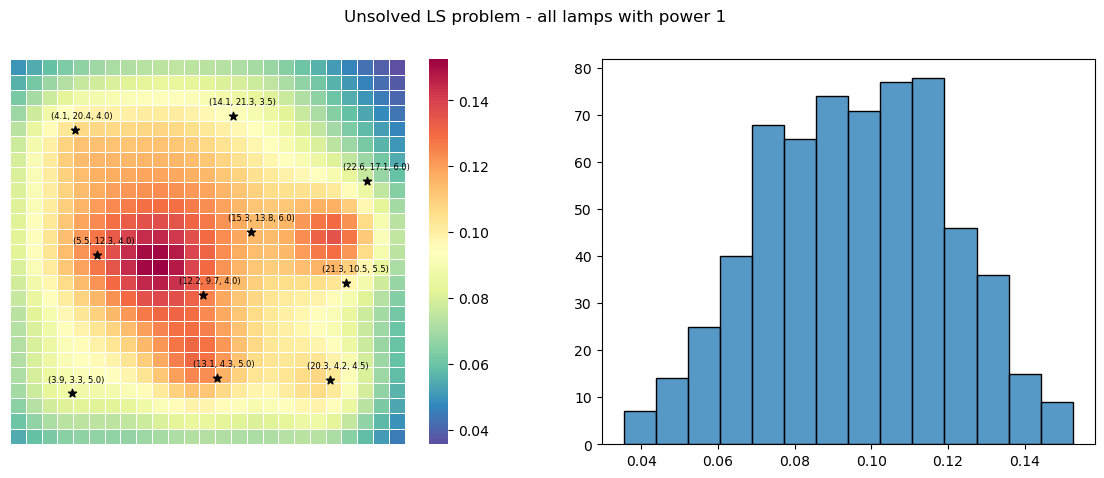

In [166]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# heatmap
sns.heatmap(
    l_unsol.reshape(25, 25), 
    ax=axes[0],
    linewidth=0.50,
    cmap=sns.color_palette("Spectral_r", as_cmap=True),
    xticklabels=[], 
    yticklabels=[]
)

# plotting lamps coordinates
axes[0].scatter(
    lamps[:, 0], lamps[:, 1],
    marker='*', color='black'
)

# lamp annotation
for i in range(10):
    axes[0].text(
        lamps[i][0]-1.5, 
        lamps[i][1]+0.75,
        '({}, {}, {})'.format(
            lamps[i][0], 
            lamps[i][1], 
            lamps[i][2]
        ),
        fontdict={
            'size': 6
        }
    )

# histogram
sns.histplot(ax=axes[1], x=l_unsol)

axes[0].invert_yaxis()
axes[1].set(ylabel='')
fig.suptitle('Unsolved LS problem - all lamps with power 1')

plt.show()

## Solving the least squares problem
---

The closed form of the solution for the LS problem is:

$$
    p = (A^TA)^{-1}A^Tl
$$

where the vector `l` is set to ones:

In [167]:
# calculating power for unfirom lighting
p_sol = np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), l_ones)

# calculation of l for p_ones (625 x 1)
l_sol = A @ p_sol

# calculate rms
rms = math.sqrt( sum ( (l_sol - l_ones ) ** 2 ) )
print('RMS: {:.2f}'.format(rms))

RMS: 3.64


The illumination of the room and the corresponding illumination histogram are:

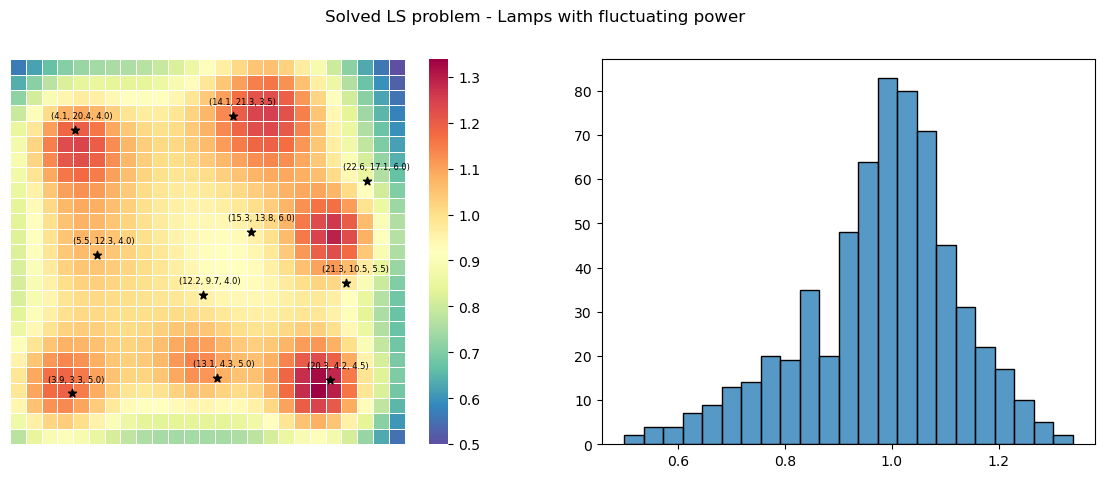

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# heatmap
sns.heatmap(
    l_sol.reshape(25, 25), 
    ax=axes[0],
    linewidth=0.50,
    cmap=sns.color_palette("Spectral_r", as_cmap=True),
    xticklabels=[], 
    yticklabels=[]
)

# plotting lamps coordinates
axes[0].scatter(
    lamps[:, 0], lamps[:, 1],
    marker='*', color='black'
)

# lamp annotation
for i in range(10):
    axes[0].text(
        lamps[i][0]-1.5, 
        lamps[i][1]+0.75,
        '({}, {}, {})'.format(
            lamps[i][0], 
            lamps[i][1], 
            lamps[i][2]
        ),
        fontdict={
            'size': 6
        }
    )

# histogram
sns.histplot(ax=axes[1], x=l_sol)

axes[0].invert_yaxis()
axes[1].set(ylabel='')
fig.suptitle('Solved LS problem - Lamps with fluctuating power')

plt.show()

## Solving the constrained least squares problem
---

The problem statement for the problem now becomes:

$$
    argmin ||Ap - l||_2 ^2
$$

under the constraint:

$$
    \sum \limits _{i=1} ^{10} p_i=10
$$

In [162]:
def minimization_function(p):
    """
    L2 norm minimization function
    """
    return np.linalg.norm(
        np.dot(A, p) - l_ones, ord=2
    ) ** 2

cons = [{
    'type': 'eq',
    # sum of powers equal to 10 constraint
    'fun': lambda p: 10 - np.sum(p)
}]

res = scipy.optimize.minimize(
    fun=minimization_function,
    x0=[100 for i in range(10)], 
    method='SLSQP',
    bounds = [(0, np.Inf) for p in range(10)],
    constraints=cons
)

p_solc = res.x
for p in p_solc:
    print('{:.2f}'.format(p), end=" ")

0.00 2.86 0.00 0.00 7.14 0.00 0.00 0.00 0.00 0.00 

We can see that the minimization function reached a local minimum where indeed the sum of powers is equal to one, but only 2 lamps are active.

In [163]:
# calculation of l for p_ones (625 x 1)
l_solc = A @ p_solc

# calculate rms
rms = math.sqrt( sum ( (l_solc - l_ones ) ** 2 ) )
print('RMS: {:.2f}'.format(rms))

RMS: 21.96


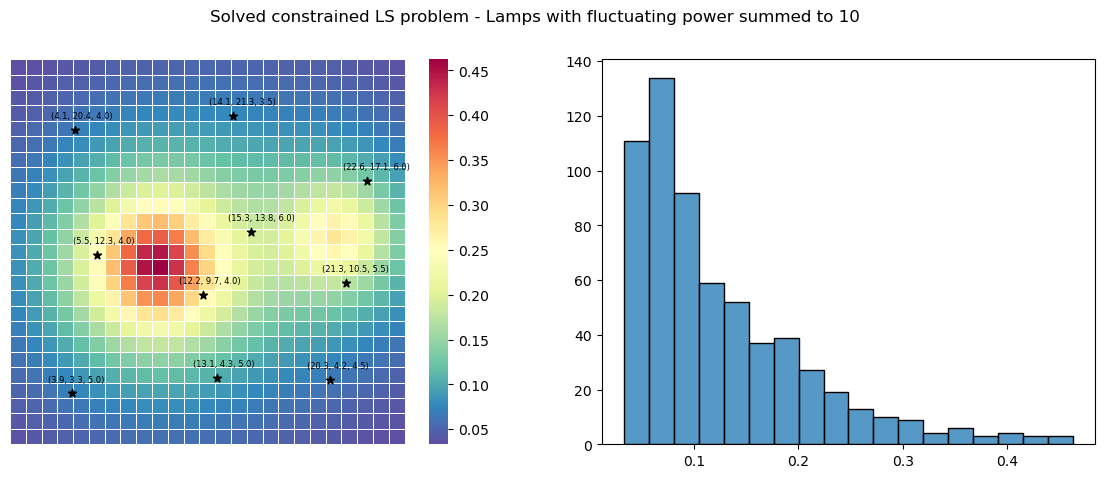

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# heatmap
sns.heatmap(
    l_solc.reshape(25, 25), 
    ax=axes[0],
    linewidth=0.50,
    cmap=sns.color_palette("Spectral_r", as_cmap=True),
    xticklabels=[], 
    yticklabels=[]
)

# plotting lamps coordinates
axes[0].scatter(
    lamps[:, 0], lamps[:, 1],
    marker='*', color='black'
)

# lamp annotation
for i in range(10):
    axes[0].text(
        lamps[i][0]-1.5, 
        lamps[i][1]+0.75,
        '({}, {}, {})'.format(
            lamps[i][0], 
            lamps[i][1], 
            lamps[i][2]
        ),
        fontdict={
            'size': 6
        }
    )

# histogram
sns.histplot(ax=axes[1], x=l_solc)

axes[0].invert_yaxis()
axes[1].set(ylabel='')
fig.suptitle('Solved constrained LS problem - Lamps with fluctuating power summed to 10')

plt.show()